## Build Weather Model

### Objective

* Daily weather model, a set of a few parameters that describes the weather conditions for each disc golf game

### Rationale

* Why This?  In order to run predictive analytics on scores, we need to simplify the weather data down to just a few input parameters.  

* Why Me?  Since I will be building the weather - performance model, I am best suited to process these files.

* Why Now? Building the weather data is a necessary pre-requisite to evaluating different time-series models

### Requirements

* Pandas 0.24.2
* Numpy 1.16.4
* Matplotlib 3.1.0

### Input / Output

* The notebook should be in the folder `'models/notebooks` with the data in `models/wx_record/wx_station_by_date`

* Input files have the form `{station-id}_{mmddyy}_p01.csv` where `station-id` is a personal weather station id, e.g. KCASANFR1086, and the date is something like 033119

* Output file will be a csv that can be read into the database. `models/wx_model_data/wx_model.csv`

### Import / Set-Up

In [87]:
import pandas as pd
import numpy as np
import glob
import datetime as dt
import pytz
import json
import matplotlib.pyplot as plt
%matplotlib inline

In [88]:
# Make one big dataFrame, with a station_id added from filename
wx_df = pd.DataFrame()
filenames = glob.glob('../wx_record/wx_station_by_date/*.csv')
for filename in filenames:
    station_id = filename.split('_')[-3].split('\\')[-1]
    df_temp = pd.read_csv(filename, parse_dates=['time'])
    df_temp['station_id'] = station_id
    wx_df = wx_df.append(df_temp)
# Drop all NaN
wx_df = wx_df.dropna()
print(len(wx_df))
wx_df.head()

114901


,Unnamed: 0,time,T,w_dir,w_spd,w_gust,rh,precip,station_id
1,1,2019-07-23 23:59:00,60.1,198.0,12.1,14.8,92.0,0.0,KCAALBAN12
2,2,2019-07-24 23:59:00,62.7,202.0,7.7,10.1,87.8,0.0,KCAALBAN12
3,3,2019-07-25 22:49:00,59.8,213.0,11.5,14.7,93.5,0.0,KCAALBAN12
4,4,2019-07-23 00:04:00,59.4,192.0,12.1,13.9,91.6,0.0,KCAALBAN12
5,5,2019-07-23 00:09:00,59.4,188.0,11.6,13.4,92.0,0.0,KCAALBAN12


In [89]:
# Drop stations that we have determined do not represent the weather at courses.  To date,
# these are:
# KCAALBAN12 -- does not represent Aquatic Park weather
# KCACASTR49 -- does not represent Lake Chabot weather
# KCAOAKLA170 -- station missing wind weather
wx_df = wx_df[wx_df.station_id != 'KCACASTR49']
wx_df = wx_df[wx_df.station_id != 'KCAALBAN12']
wx_df = wx_df[wx_df.station_id != 'KCAOAKLA170']
len(wx_df)

106650

In [90]:
# Import the weather station data
station_df = pd.read_csv('../geo/nearby_wunder_pws.csv')
station_df.head()

,station_id,latitude,longitude,elevation,course_id,hardware,comments
0,KCABERKE85,37.865000,-122.28700,72.0,2,AcuRite Pro Weather Center,no wind gust prior to 2018 and no wind guest i...
1,KCAALBAN12,37.889000,-122.30600,72.0,2,Ambient Weather WS 1002 WiFi,winds appear significantly different on 7/24/19
2,KCABERKE104,37.859000,-122.28200,76.0,2,Ambient Weather WS 1400 IP,NaN
3,KCABERKE28,37.852000,-122.28800,92.0,2,Davis Vantage Pro II - weewx 1.14.1,NaN
4,KCASANFR1443,37.777023,-122.48484,240.0,0,Ambient Weather WS 2902,NaN


In [91]:
wx_df = wx_df.merge(station_df, on="station_id")
wx_df['w_rad'] = (90 - wx_df['w_dir']) * 3.14159265359 / 180
wx_df['w_u'] = wx_df['w_spd'] * wx_df['w_rad'].apply(np.cos)
wx_df['w_v'] = wx_df['w_spd'] * wx_df['w_rad'].apply(np.sin)
wx_df = wx_df.drop(columns = ['comments', 'w_rad','Unnamed: 0']).set_index('time')
print(len(wx_df))
wx_df.head()

106650


,T,w_dir,w_spd,w_gust,rh,precip,station_id,latitude,longitude,elevation,course_id,hardware,w_u,w_v
time,,,,,,,,,,,,,,
2019-01-12 00:04:55,52.0,194.0,0.0,0.0,98.0,0.0,KCABERKE104,37.859,-122.282,76.0,2,Ambient Weather WS 1400 IP,-0.0,-0.0
2019-01-12 00:09:59,51.0,194.0,0.0,0.0,98.0,0.0,KCABERKE104,37.859,-122.282,76.0,2,Ambient Weather WS 1400 IP,-0.0,-0.0
2019-01-12 00:14:47,51.0,187.0,0.0,0.0,97.0,0.0,KCABERKE104,37.859,-122.282,76.0,2,Ambient Weather WS 1400 IP,-0.0,-0.0
2019-01-12 00:19:51,51.0,182.0,0.0,0.0,97.0,0.0,KCABERKE104,37.859,-122.282,76.0,2,Ambient Weather WS 1400 IP,-0.0,-0.0
2019-01-12 00:24:55,51.0,138.0,0.0,0.0,97.0,0.0,KCABERKE104,37.859,-122.282,76.0,2,Ambient Weather WS 1400 IP,0.0,-0.0


In [92]:
# Lastly, get the course timing data 
with open('../geo/course_timings.json', 'r') as timings_file:
    course_timings = json.load(timings_file)

### Process Data

In [93]:
max_course_id = wx_df.course_id.max()
max_course_id

2

In [94]:
def compute_weighting_factor(t : float, ramp_start: float, ramp_end: float, game_length: float) -> float:
    """Computes the player weighting factor at time t given that players start playing games of length 'game_length'
    in either a rolling fashion between 'ramp_start' and 'ramp_end', or if 'ramp_start' == 'ramp_end', there is a fixed
    starting point.  Time units must be consistent, the expected form is a number representing minutes past midnight.  
    Returns a weighting factor between 0 and 1.  See the function 'compute_weight_by_course_and_time_of_day' for 
    additional info.  Limited error handling is implemented."""
    
    weight = 0.0  #Default case for when no one is playing 
    if game_length == 0:  #Re-set to default to avoid division by zero later
        game_length = 180
    if ramp_start > ramp_end:   #Fix to avoid weights outside of [0, 1]
        ramp_start, ramp_end = ramp_end, ramp_start
    if ramp_start == ramp_end:   #Fixed starting point case
        if (t >= ramp_start) & (t <= (ramp_end + game_length)):
            weight = 1.0
    else:  #Rolling case
        if (ramp_end - ramp_start) > game_length:  #Some players finish before others begin
            if (t >= ramp_start) & (t < (ramp_start + game_length)):
                weight = (t - ramp_start) / game_length
            elif (t >= (ramp_start + game_length)) & (t < (ramp_end - game_length)):
                weight = 1.0
            elif (t > ramp_end) & (t <= (ramp_end + game_length)):
                weight = 1.0 - (t - ramp_end) / game_length
        else: #All players begin before first player ends
            if (t >= ramp_start) & (t < ramp_end):
                weight = (t - ramp_start) / (ramp_end - ramp_start)
            elif (t >= ramp_end) & (t < (ramp_start + game_length)):
                weight = 1.0
            elif (t >= (ramp_start + game_length)) & (t < (ramp_end + game_length)):
                weight = 1.0 - (t - ramp_start - game_length) / (ramp_end - ramp_start)
    
    return weight

In [95]:
def compute_weight_by_course_and_time_of_day(course_id: int, mins_since_midnight: float, dst: bool) -> float:
    """Given a course_id and time of day (in minutes since midnight), plus a boolean indicator (dst) of whether 
    Daylight Savings Time is in effect, compute a weight [0 to 1] to assign to resampled weather
    observations centered on this time of day.  This function expects that a dictionary named course_timings 
    will have been created by importing the course_timings.json file."""
    
    #Individual course data
    # Course_id 0 (Golden Gate Park) -- rolling start 7:30 - 10 AM on Sundays, 3 hour game
    # Course_id 1 (Chabot Lake) -- rolling start 8:00 AM - 2:00 PM, 3 hour game
    # Course_id 2 (Aquatic Park) -- rolling start 3:30 - 6 PM, 3 hour game during Daylight Savings Time
    # Course_id 2 (Aquatic Park) -- rolling start 9:00 - 10:30 AM, 3 hour game otherwise
    # The model assumes a uniform distribution of player start times within the rolling window. It puts 0 
    # outside of the window, and 1 for the maximum number of people playing.  For example, if there is a rolling
    # start at 7 AM - 9 AM and each game is 3 hours long, then times before 7 AM are weighted 0, the weight ramps
    # up to 1 by 9 AM, stays at 1 until 10 AM (when players who started at 7 AM are done), and then ramps down to 0
    # by 12 PM, when the players who started last complete their game.  All ramps are linear. 
    
    if not course_timings:
        print('Missing course timing data.  Please update the notebook to import "course_timings.json"')
        raise IOError
    
    ramp_up_start = 360   #Set some default values in case the course_id is not found
    ramp_up_end = 900
    game_length = 180
    # Now look for a course that matches 'course_id' in the course timings, and if one is found, replace the defaults
    for course in course_timings['courses']:
        if course.get('course_id',0) == course_id:
            start_times_key = 'start_times'  #Default keys for when Daylight Savings Time does not matter
            end_times_key = 'end_times'
            if course.get('dst_matters',False):
            # dst_matters == True means the rules differ based on whether Daylight Savings Time is in effect
                if dst:
                    start_times_key = 'start_times_dst'
                    end_times_key = 'end_times_dst'
                else: 
                    start_times_key = 'start_times_nondst'
                    end_times_key = 'end_times_nondst'
            if course[start_times_key].get('type','fixed') == 'rolling':
                ramp_up_start = course[start_times_key].get('rolling_earliest',360)
                ramp_up_end = course[start_times_key].get('rolling_latest',900)
            else:
                ramp_up_start = course[start_times_key].get('start_time',360)
                ramp_up_end = ramp_up_start
            game_length_type = course[end_times_key].get('type','fixed_length')
            if game_length_type == 'fixed_length':
                game_length = course[end_times_key].get('fixed_length',180)
            else:
                game_length = 180  #Nothing besides fixed_length implemented 
            break  #No need to continue searching if the course info has been found
    
    #Executes on completion of for loop, either by break or because course not found
    weighting_factor = compute_weighting_factor(mins_since_midnight, ramp_up_start, ramp_up_end, game_length)
    return weighting_factor 

In [96]:
def directional_difference(dir1 : float, dir2 : float) -> float:
    """This special function determines the difference between two directions in degrees.  It takes into account that
    differences of more than 180 degrees are not possible."""
    
    diff = dir1 - dir2
    if (diff > 180):
        diff = 360 - diff
    elif (diff < -180):
        diff = diff + 360
    return diff

In [115]:
weighted_data = pd.DataFrame()
for course_index in range(max_course_id + 1):
    course_df = wx_df[wx_df.course_id == course_index]
    dates_list = [item.date() for item in course_df.index]
    unique_days = list(set(dates_list))
    for date_of_game in unique_days:
        course_by_date_df = course_df[date_of_game.isoformat()]
        resampled_df = course_by_date_df[['T','w_dir','w_spd','w_gust','rh','precip','w_u','w_v']].resample('60T').agg({'T':'mean',
                                        'w_dir':'mean','w_spd':'mean','w_gust':'max','rh':'mean','precip':'mean','w_u':'mean',
                                        'w_v':'mean'})
  
        resampled_df = resampled_df.reset_index()
        resampled_df = resampled_df.dropna()
        resampled_df['minute_of_day'] = resampled_df['time'].dt.hour * 60 + resampled_df['time'].dt.minute + 30
        resampled_df = resampled_df.drop(columns = ['time'])
        # Check whether Daylight Savings Time is in effect because this changes the way time of day is weighted 
        dst_test_time = dt.datetime.combine(date_of_game, dt.time.fromisoformat('05:00:00'))
        # Localize time to US Pacific and compute numbers of hours it is offset from UTC.  If 7, then DST is in effect.
        dst_in_effect = False
        check_UTC_offset = (pytz.timezone('US/Pacific').localize(dst_test_time).utcoffset().seconds / 3600 - 24) * -1
        if check_UTC_offset == 7.0:
            dst_in_effect = True
        resampled_df['weight_factor'] = resampled_df['minute_of_day'].apply(lambda x: \
                                        compute_weight_by_course_and_time_of_day(course_index, x, dst_in_effect))   
        if resampled_df['weight_factor'].sum() > 0:
            resampled_df['weighted_T'] = resampled_df['weight_factor'] * resampled_df['T']
            resampled_df['weighted_w_dir'] = resampled_df['weight_factor'] * resampled_df['w_dir']
            resampled_df['weighted_w_spd'] = resampled_df['weight_factor'] * resampled_df['w_spd']
            resampled_df['weighted_w_gust'] = resampled_df['weight_factor'] * resampled_df['w_gust']
            resampled_df['weighted_rh'] = resampled_df['weight_factor'] * resampled_df['rh']
            resampled_df['weighted_precip'] = resampled_df['weight_factor'] * resampled_df['precip']
            resampled_df['weighted_w_u'] = resampled_df['weight_factor'] * resampled_df['w_u']
            resampled_df['weighted_w_v'] = resampled_df['weight_factor'] * resampled_df['w_v']

            # Special formula for computing the variability of wind gust and direction
            mean_gust = resampled_df['weighted_w_gust'].sum() / resampled_df['weight_factor'].sum()
            resampled_df['w_gust_var'] = resampled_df['weight_factor'] * (resampled_df['w_gust'] - mean_gust) * \
                                         (resampled_df['w_gust'] - mean_gust)
            mean_dir = resampled_df['weighted_w_dir'].sum() / resampled_df['weight_factor'].sum()
            resampled_df['w_dir_var'] = resampled_df['weight_factor'] * resampled_df['w_dir'].apply(directional_difference,args=(mean_dir,)) * \
                                        resampled_df['w_dir'].apply(directional_difference,args=(mean_dir,))        
            resampled_df['w_uv_var'] = resampled_df['w_gust_var'] * resampled_df['w_dir_var']
            #This formula is needed to make the course_index come out correctly when the DataFrame is processed below
            resampled_df['course_id'] = course_index / len(resampled_df) * resampled_df['weight_factor'].sum()
            if date_of_game == dt.date(2019,3,11):
                print('What the heck!')
                print(resampled_df['weight_factor'].sum())
                print(resampled_df)
            weighted_data[date_of_game] = resampled_df.sum() / resampled_df['weight_factor'].sum()
        #End of if statement
    #End of for loop
weighted_data = weighted_data.transpose()
weighted_data.head()

,T,w_dir,w_spd,w_gust,rh,precip,w_u,w_v,minute_of_day,weight_factor,...,weighted_w_spd,weighted_w_gust,weighted_rh,weighted_precip,weighted_w_u,weighted_w_v,w_gust_var,w_dir_var,w_uv_var,course_id
2018-11-11,476.367079,534.978322,31.781122,97.333333,278.815649,0.000000,23.060804,16.607698,5760.0,1.0,...,5.091894,15.866667,26.821613,0.000000,2.632290,3.792724,2.382222,115.436274,111.370212,0.0
2018-12-09,395.658120,575.482906,24.366453,87.333333,724.981838,0.000000,12.257811,15.395675,5760.0,1.0,...,3.919444,13.133333,90.988889,0.000000,2.100778,2.822686,2.915556,490.203981,41.108702,0.0
2018-12-17,266.250000,882.500000,0.000000,27.500000,460.000000,0.125000,0.000000,0.000000,4800.0,1.0,...,0.000000,9.000000,93.000000,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
2019-01-06,419.658180,1400.452196,35.542218,166.333333,721.367440,0.527396,-5.651286,-23.637681,5760.0,1.0,...,4.384722,20.933333,89.798611,0.105625,0.829178,-3.227827,6.995556,214.376551,906.500313,0.0
2019-08-03,244.249762,942.969841,8.457460,49.666667,419.515794,0.002905,-5.785337,-5.674658,1690.0,1.0,...,3.021159,12.866667,96.149492,0.000203,-2.264058,-1.859965,1.448889,15.888444,17.074903,0.0


In [116]:
#Prepare and export df
weighted_data = weighted_data.reset_index()
weighted_data = weighted_data.rename(columns = {'index':'date'})
weighted_data = weighted_data.drop(columns = ['T','w_dir','w_spd','w_gust','rh','precip',
                                              'w_u','w_v','minute_of_day','weight_factor'])
weighted_data['course_id'] = weighted_data['course_id'].astype('int')
weighted_data.to_csv('../wx_model_data/wx_model.csv')
weighted_data.head()

,date,weighted_T,weighted_w_dir,weighted_w_spd,weighted_w_gust,weighted_rh,weighted_precip,weighted_w_u,weighted_w_v,w_gust_var,w_dir_var,w_uv_var,course_id
0,2018-11-11,62.987163,59.560057,5.091894,15.866667,26.821613,0.000000,2.632290,3.792724,2.382222,115.436274,111.370212,0
1,2018-12-09,49.491667,68.116667,3.919444,13.133333,90.988889,0.000000,2.100778,2.822686,2.915556,490.203981,41.108702,0
2,2018-12-17,52.000000,135.000000,0.000000,9.000000,93.000000,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0
3,2019-01-06,51.505556,153.133333,4.384722,20.933333,89.798611,0.105625,0.829178,-3.227827,6.995556,214.376551,906.500313,0
4,2019-08-03,56.631841,226.426190,3.021159,12.866667,96.149492,0.000203,-2.264058,-1.859965,1.448889,15.888444,17.074903,0


In [117]:
len(weighted_data)

157

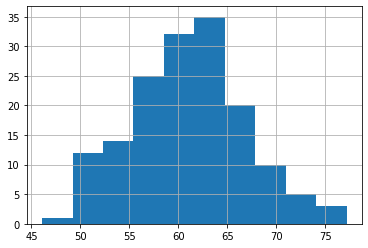

In [126]:
weighted_data.weighted_T.hist()

In [123]:
print(60*60+120*120+120*120)

32400
